# Static Ordinal Regression with Diabetes toy dataset using TensorFlow
---------

## Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow.keras.optimizers import Adam

In [3]:
sys.path.append(os.path.abspath(os.path.join('../src')))
from clm_tensorflow.cumulative_link import CumulativeLink
from clm_tensorflow.negative_log_likelihood import NegativeLogLikelihood

## Data Preprocessing

In [4]:
# Set the random state
random_state=1

In [5]:
# Load Data
X, y = load_diabetes(return_X_y=True, as_frame=False)

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [7]:
# Separate disease progression into ordinal classes
est = KBinsDiscretizer(n_bins=5, encode='ordinal')
est.fit(y_train.reshape(-1, 1))
y_train_ordinal = est.transform(y_train.reshape(-1, 1))
y_test_ordinal = est.transform(y_test.reshape(-1, 1))

### Visualize feature distributions of first label

In [ ]:
sns.pairplot(preprocess_X_df(X_train).merge(preprocess_y_df(y_train)[['stay_id', 'los_geq_3_days']], on='stay_id').iloc[:,1:], hue='los_geq_3_days')

# Ordinal Classification

In [19]:
n_classes = int(y_train_ordinal.max()+1)

In [24]:
input = tf.keras.Input(shape=(X_train.shape[-1],))
dense_layer = tf.keras.layers.Dense(1)(input)

sorted_random_values = tf.sort(tf.random.normal(shape=(n_classes - 1,)))

cutpoints_layer = tfp.layers.VariableLayer(shape=(n_classes - 1,),
                                            initializer=lambda shape, dtype: 
                                                tfp.util.TransformedVariable(
                                                    initial_value=sorted_random_values,
                                                    bijector=tfb.Scale(scale=1.),
                                                    dtype=dtype),
                                            # regularizer=tf.keras.regularizers.l2(),
                                            )(input)
ordinal_layer = tfp.layers.DistributionLambda(lambda t: CumulativeLink(loc=t[0], cutpoints=t[1]))([dense_layer, cutpoints_layer])
ordinal_model = tf.keras.Model(inputs=input, outputs=ordinal_layer)

ordinal_model.compile(optimizer=Adam(lr=0.05), loss=NegativeLogLikelihood())
history = ordinal_model.fit(X_train, y_train_ordinal, epochs=100)

Epoch 1/100
12/12 [==============================] - 0s 2ms/step - loss: 1.7609
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4985
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4644
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4256
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3997
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3897
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3817
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3822
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3707
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3452
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3408
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3289
Epoch 13/100
12/12 [=================

<function matplotlib.pyplot.show(close=None, block=None)>

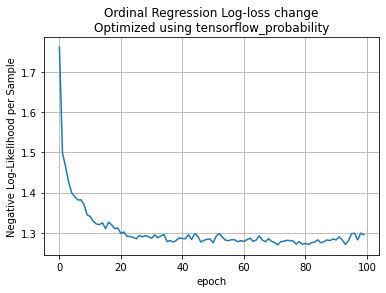

In [25]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [27]:
# Model Summary
tf.print(ordinal_model.summary())
print(ordinal_model.trainable_weights)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            11          input_4[0][0]                    
__________________________________________________________________________________________________
variable_layer_1 (VariableLayer (4,)                 4           input_4[0][0]                    
__________________________________________________________________________________________________
distribution_lambda_1 (Distribu ((None, 1), (None, 1 0           dense_3[0][0]                    
                                                                 variable_layer_1[0][0]

In [23]:
# Predict probability scores for each dataset
y_train_pred = ordinal_model.predict(X_train)
y_test_pred = ordinal_model.predict(X_test)
# y_scores = [y_score_train, y_score_valid, y_score_test]

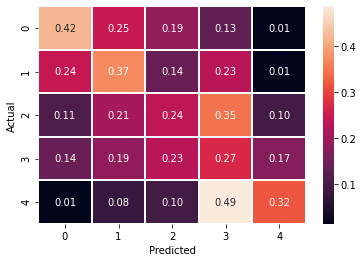

In [28]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train_ordinal, y_train_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

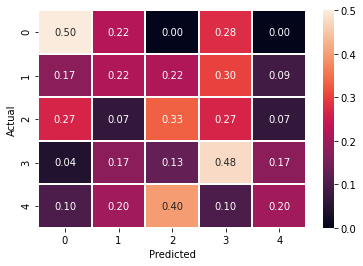

In [29]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_test_ordinal, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [ ]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 3 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

## >7 days

In [ ]:
# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='bce', metrics=['accuracy', 'bce'])
model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['los_geq_7_days'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['los_geq_7_days']),
    )

In [ ]:
# Predict prob scores for each dataset
y_score_train = model.predict(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = model.predict(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = model.predict(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

In [ ]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 7 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

## >11 days

In [ ]:
# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='bce', metrics=['accuracy', 'bce'])
model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['los_geq_11_days'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['los_geq_11_days']),
    )

In [ ]:
# Predict probability scores for each dataset
y_score_train = model.predict(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = model.predict(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = model.predict(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

In [ ]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 11 days\nMethod: TensorFlow Logistic Regression')
plt.tight_layout()
plt.show()

# Ordinal Classification

### Training and model summary

In [ ]:
# Determine number of labels
R = preprocess_y_df(y_valid)['ordinal_label'].max() + 1

# Initialize cutpoints uniformly between 0-1 using number of labels
cutpoints = tf.Variable(
    initial_value=tf.range(R-1, dtype=np.float32) / (R-2),
    trainable=True,
    )

# Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.OrderedLogistic(cutpoints=cutpoints, loc=t))
])
model.compile(optimizer='adam', loss=OrdinalLoss())
history = model.fit(
    x=preprocess_X_df(X_train, normalize=True).iloc[:,1:],
    y=preprocess_y_df(y_train)['ordinal_label'],
    epochs=10,
    validation_data=(preprocess_X_df(X_valid, normalize=True).iloc[:,1:], preprocess_y_df(y_valid)['ordinal_label']),
    )

In [ ]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [ ]:
# Model Summary
tf.print(model.summary())
print(model.trainable_weights)

In [ ]:
# Confusion Matrix
y = preprocess_y_df(y_train)['ordinal_label'].to_numpy()
y_predict = model.predict(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy())

cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [ ]:
# Compute ordinal probabilities for each label
y_probas_train = model(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()
y_probas_valid = model(preprocess_X_df(X_valid, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()
y_probas_test = model(preprocess_X_df(X_test, normalize=True).iloc[:,1:].to_numpy()).categorical_probs().numpy().squeeze()


## >3 days

In [ ]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq3 = y_probas_train[:,1:].sum(axis=1)
y_probas_valid_geq3 = y_probas_valid[:,1:].sum(axis=1)
y_probas_test_geq3 = y_probas_test[:,1:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

In [ ]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 3 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()

## >7 days

In [ ]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq7 = y_probas_train[:,2:].sum(axis=1)
y_probas_valid_geq7 = y_probas_valid[:,2:].sum(axis=1)
y_probas_test_geq7 = y_probas_test[:,2:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

In [ ]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 7 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()

## >11 days

In [ ]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq11 = y_probas_train[:,3:].sum(axis=1)
y_probas_valid_geq11 = y_probas_valid[:,3:].sum(axis=1)
y_probas_test_geq11 = y_probas_test[:,3:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

In [ ]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 11 days\nMethod: TensorFlow Ordered Logistic')
plt.tight_layout()
plt.show()